In [1]:
!pip install dask[complete] torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [3]:
df = dd.read_csv("HI-Small_Trans.csv")


In [4]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, Timestamp to Is Laundering
dtypes: float64(2), int64(3), string(6)

In [6]:
data = df.compute()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137979 entries, 0 to 137978
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Timestamp           137979 non-null  string 
 1   From Bank           137979 non-null  int64  
 2   Account             137979 non-null  string 
 3   To Bank             137979 non-null  int64  
 4   Account.1           137979 non-null  string 
 5   Amount Received     137979 non-null  float64
 6   Receiving Currency  137979 non-null  string 
 7   Amount Paid         137979 non-null  float64
 8   Payment Currency    137979 non-null  string 
 9   Payment Format      137979 non-null  string 
 10  Is Laundering       137979 non-null  int64  
dtypes: float64(2), int64(3), string(6)
memory usage: 16.5 MB


In [8]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [9]:
data.rename(columns = {'Account':'From acc'}, inplace = True)
data.rename(columns = {'Account.1':'To acc'}, inplace = True)

In [10]:
data.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137979 entries, 0 to 137978
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Timestamp           137979 non-null  datetime64[ns]
 1   From Bank           137979 non-null  int64         
 2   From acc            137979 non-null  string        
 3   To Bank             137979 non-null  int64         
 4   To acc              137979 non-null  string        
 5   Amount Received     137979 non-null  float64       
 6   Receiving Currency  137979 non-null  string        
 7   Amount Paid         137979 non-null  float64       
 8   Payment Currency    137979 non-null  string        
 9   Payment Format      137979 non-null  string        
 10  Is Laundering       137979 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), string(5)
memory usage: 14.9 MB


In [12]:
print(data.isnull().sum())


Timestamp             0
From Bank             0
From acc              0
To Bank               0
To acc                0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


In [13]:
print(data.shape)

(137979, 11)


In [14]:
data = data.drop_duplicates(keep = 'first')
data.shape

(137979, 11)

In [15]:
data.nunique()

Timestamp                 45
From Bank               6136
From acc              102980
To Bank                 5254
To acc                100412
Amount Received        93931
Receiving Currency        15
Amount Paid            94323
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

In [16]:
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month

In [17]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]

In [18]:
print(len(Laundering))
print(len(Non_Laundering))

24
137955


In [19]:
Laundering.nunique()

Timestamp             22
From Bank              3
From acc               4
To Bank               21
To acc                24
Amount Received       24
Receiving Currency     3
Amount Paid           24
Payment Currency       3
Payment Format         4
Is Laundering          1
Year                   1
Month                  1
dtype: int64

In [20]:
inter_currency_transactionsL = Laundering[Laundering['Receiving Currency'] != Laundering['Payment Currency']]
inter_currencyL = inter_currency_transactionsL.groupby(['Receiving Currency', 'Payment Currency']).size().reset_index(name='Transaction Count')
inter_currencyL.describe()

,Transaction Count
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [21]:
same_currency_transactionsL = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
same_currencyL = same_currency_transactionsL.groupby('Payment Currency').size().reset_index(name='Transaction Count')

same_currencyL.describe()

,Transaction Count
count,3.000000
mean,8.000000
std,7.549834
min,1.000000
25%,4.000000
50%,7.000000
75%,11.500000
max,16.000000


In [22]:
same_currencyL

,Payment Currency,Transaction Count
0,Euro,7
1,US Dollar,16
2,Yuan,1


In [23]:
same_currL = data[data['Receiving Currency'] == data['Payment Currency']]
cross_currL = data[data['Receiving Currency'] != data['Payment Currency']]
same_count = len(same_currL)
cross_count = len(cross_currL)

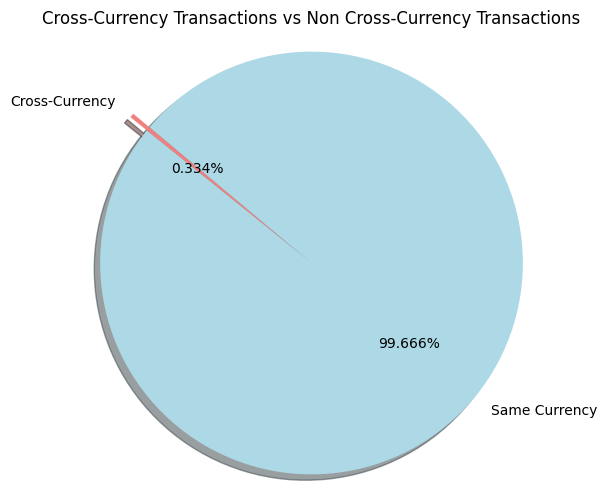

In [24]:
labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_count, same_count]
colors = ['lightcoral', 'lightblue']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

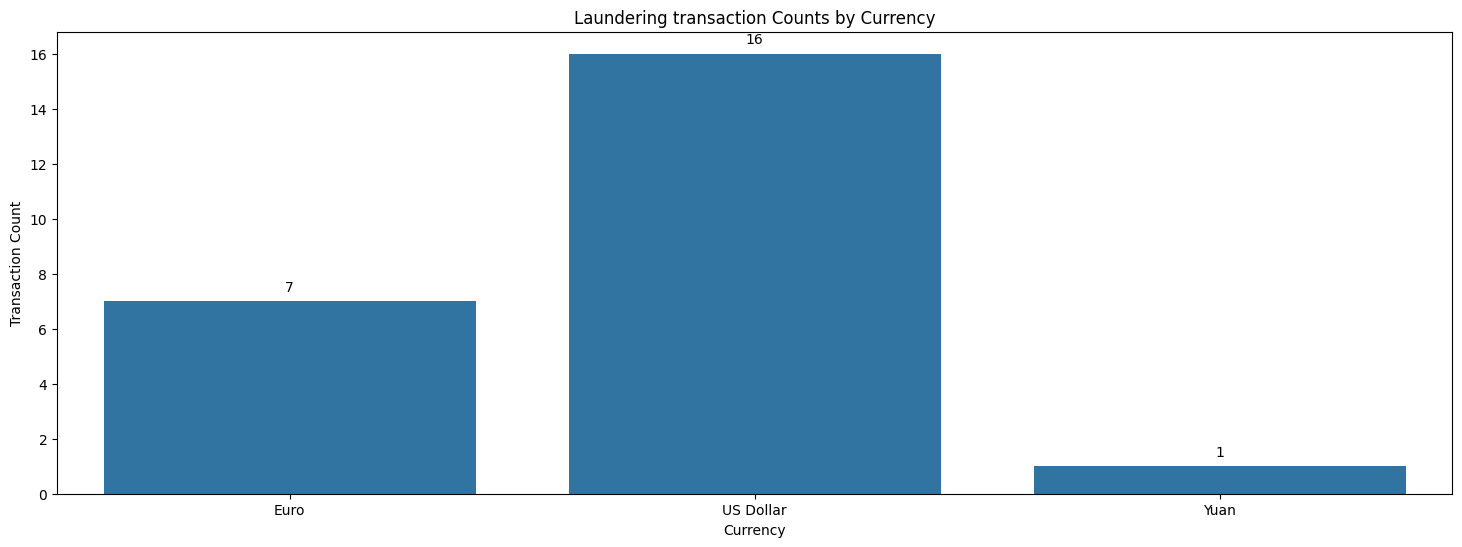

In [25]:
plt.figure(figsize=(18, 6))
ax=sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currencyL)
plt.title('Laundering transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()


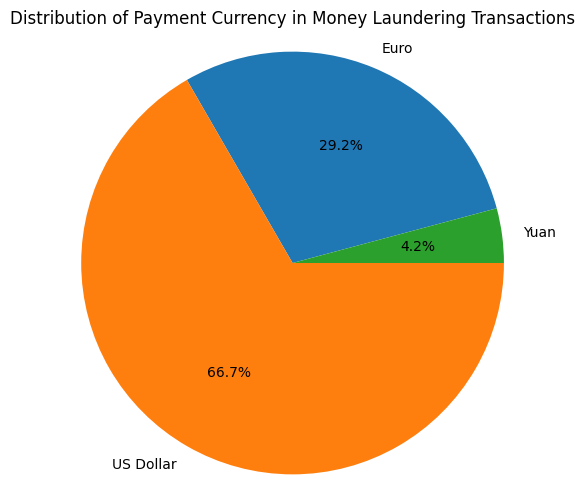

In [26]:
plt.figure(figsize=(6, 6))
plt.pie(same_currencyL['Transaction Count'], labels=same_currencyL['Payment Currency'], autopct='%1.1f%%', startangle=15)
plt.title('Distribution of Payment Currency in Money Laundering Transactions')
plt.axis('equal')
plt.show()

In [27]:
payment_format_data = data.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_format_data.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
3,Cheque,12968
4,Credit Card,12534
0,ACH,6233
2,Cash,3681
1,Bitcoin,45


In [28]:
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_formatL.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
0,ACH,17
2,Cheque,3
3,Credit Card,3
1,Cash,1


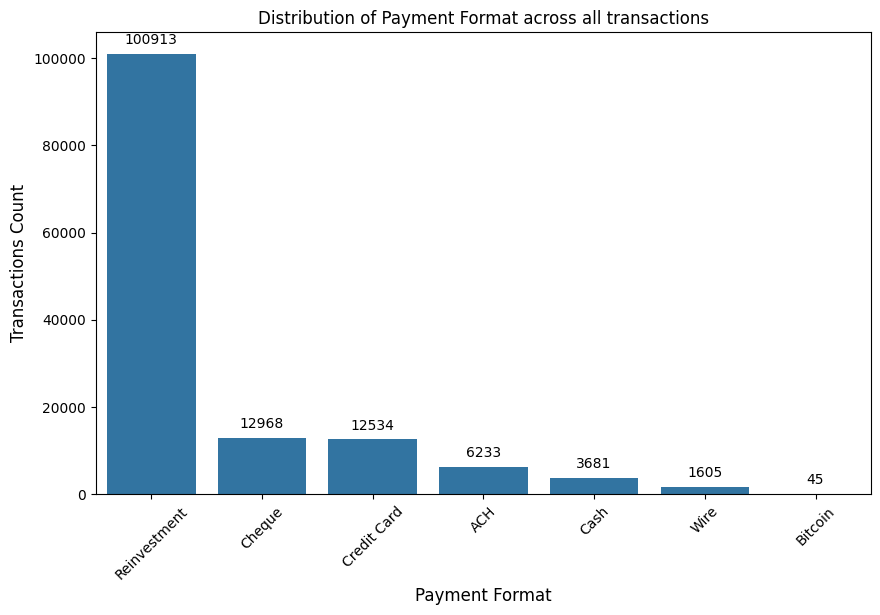

In [29]:
fig, axes = plt.subplots(figsize=(10,6))

sns.countplot(x='Payment Format',data=data, ax=axes)
axes.set_title('Distribution of Payment Format across all transactions')
axes.set_xlabel('Payment Format', fontsize=12)
axes.set_ylabel('Transactions Count', fontsize=12)
axes.tick_params(axis='x', labelrotation=45)
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 10),
                  textcoords = 'offset points')


plt.show()

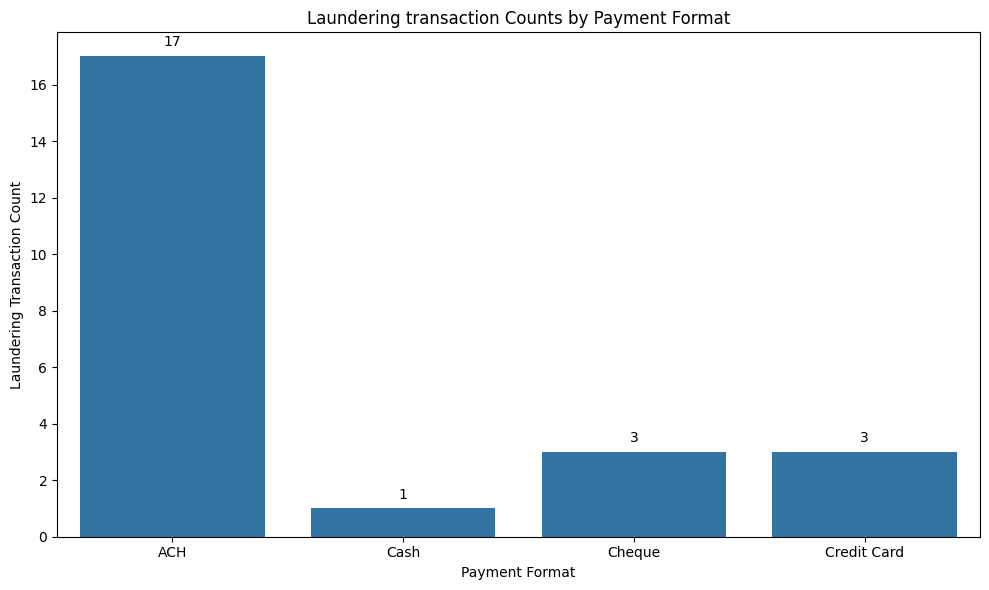

In [30]:

fig, axes = plt.subplots(figsize=(10,6))

sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes)
axes.set_title('Laundering transaction Counts by Payment Format')
axes.set_xlabel('Payment Format')
axes.set_ylabel('Laundering Transaction Count')
plt.tight_layout()

for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 10),
                  textcoords = 'offset points')

plt.show()

(-1.0999970806391584,
 1.099999860982817,
 -1.0999999644054763,
 1.0999992525149966)

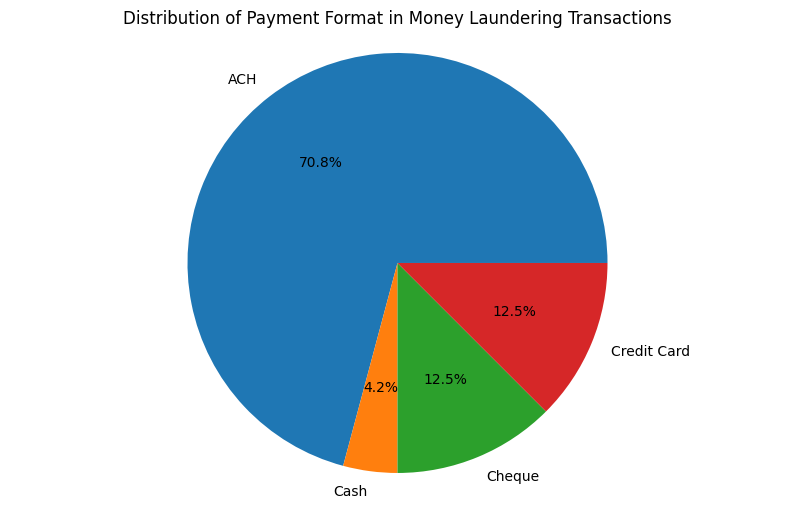

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

ax.pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
ax.set_title('Distribution of Payment Format in Money Laundering Transactions')
ax.axis('equal')

<ipython-input-32-e4b81ed92047>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
<ipython-input-32-e4b81ed92047>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Day'] = Laundering['Timestamp'].dt.day


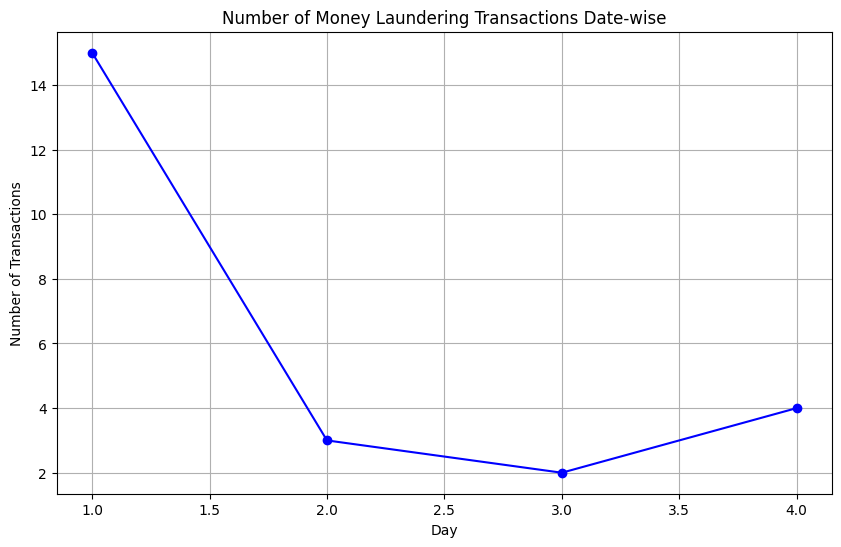

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
Laundering['Day'] = Laundering['Timestamp'].dt.day
daily_transactions = Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

<ipython-input-33-3b012e2daffe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
<ipython-input-33-3b012e2daffe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day


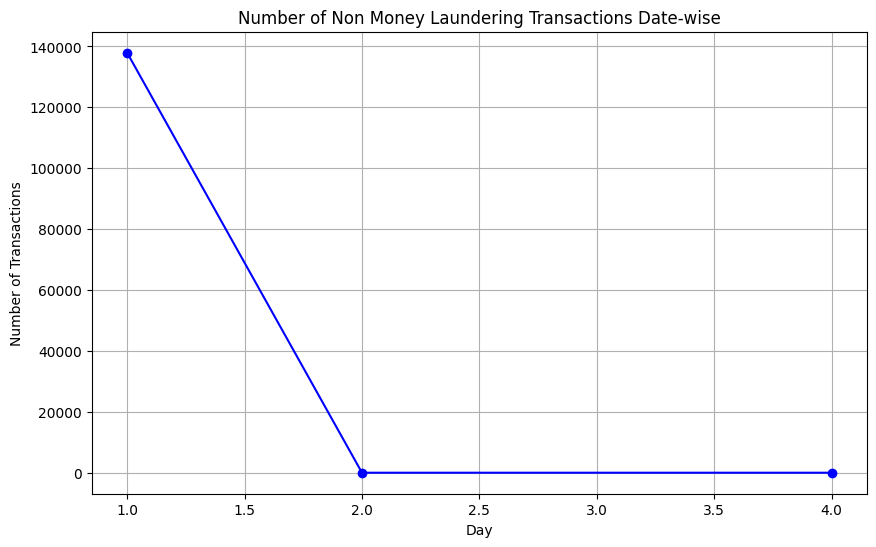

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day
daily_transactions = Non_Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Non Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [34]:
string_cols = data.select_dtypes(include=['string']).columns.tolist()
string_cols


['From acc',
 'To acc',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [35]:
for col in string_cols:
    print(col,'\n')
    print(data[col].nunique(), '\n')
    print(data[col].value_counts())

From acc 

102980 

From acc
100428660    2411
1004286A8     272
800737690      23
8001409E0      13
80026D340      13
             ... 
80271C150       1
80271CD20       1
80271D460       1
80271DE70       1
80271EB40       1
Name: count, Length: 102980, dtype: int64[pyarrow]
To acc 

100412 

To acc
812F0D2B0    37
8018859B0    17
811A57520     9
800EB5BE0     9
804EC0860     9
             ..
80271C150     1
80271CD20     1
80271D460     1
80271DE70     1
80271EB40     1
Name: count, Length: 100412, dtype: int64[pyarrow]
Receiving Currency 

15 

Receiving Currency
US Dollar            122124
Euro                  15692
Bitcoin                  44
UK Pound                 22
Yuan                     21
Rupee                    15
Yen                      12
Australian Dollar        10
Canadian Dollar          10
Mexican Peso              9
Ruble                     8
Swiss Franc               7
Brazil Real               3
Saudi Riyal               1
Shekel                    1
Name:

In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [37]:
# Select columns of type 'string'
string_cols = data.select_dtypes(include=['string']).columns.tolist()
print(string_cols)

# Quantify columns of type 'string' using Label Encoding
label_encoder = LabelEncoder()
for col in string_cols:
    if col != 'Payment Format':
        data[col] = label_encoder.fit_transform(data[col])

# Sort based on the complexity of payment
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use the map method to encode the 'Payment Format' column
data['Payment Format'] = data['Payment Format'].map(payment_map)

# Output the processed data
data.head()


['From acc', 'To acc', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,2022-09-01 00:20:00,10,101,10,81,3697.34,12,3697.34,12,7,0,2022,9
1,2022-09-01 00:20:00,3208,131,1,110,0.01,12,0.01,12,2,0,2022,9
2,2022-09-01 00:00:00,3209,132,3209,105,14675.57,12,14675.57,12,7,0,2022,9
3,2022-09-01 00:02:00,12,136,12,108,2806.97,12,2806.97,12,7,0,2022,9
4,2022-09-01 00:06:00,10,137,10,109,36682.97,12,36682.97,12,7,0,2022,9


In [38]:
# Normalizing all attributes

# Separating labels from the dataset
labels = data['Is Laundering']
data = data.drop('Is Laundering', axis=1)

# Converting the Timestamp column to Unix timestamp

data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype(int) / 10**9

# Normalizing the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)
data_normalized = scaler.transform(data)

# Converting the normalized data back to a DataFrame object and setting column names
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

# Adding the label column back to the normalized dataset
data_normalized['Is Laundering'] = labels.tolist()

# Outputting the normalized data
print(data_normalized.head())


   Timestamp  From Bank  From acc   To Bank    To acc  Amount Received  \
0  -0.992407  -0.999949 -0.998038 -0.999949 -0.998387        -0.999999   
1  -0.992407  -0.981994 -0.997456 -1.000000 -0.997809        -1.000000   
2  -1.000000  -0.981988 -0.997436 -0.981986 -0.997909        -0.999995   
3  -0.999241  -0.999938 -0.997359 -0.999938 -0.997849        -0.999999   
4  -0.997722  -0.999949 -0.997339 -0.999949 -0.997829        -0.999986   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  Year  \
0            0.714286    -0.999999          0.714286        1.000000  -1.0   
1            0.714286    -1.000000          0.714286       -0.666667  -1.0   
2            0.714286    -0.999995          0.714286        1.000000  -1.0   
3            0.714286    -0.999999          0.714286        1.000000  -1.0   
4            0.714286    -0.999986          0.714286        1.000000  -1.0   

   Month  Is Laundering  
0   -1.0              0  
1   -1.0              0  
2   -1.0

In [39]:
data_normalized=data_normalized.drop(['Month', 'Year'], axis=1)


In [40]:
data_normalized.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,-0.992407,-0.999949,-0.998038,-0.999949,-0.998387,-0.999999,0.714286,-0.999999,0.714286,1.000000,0
1,-0.992407,-0.981994,-0.997456,-1.000000,-0.997809,-1.000000,0.714286,-1.000000,0.714286,-0.666667,0
2,-1.000000,-0.981988,-0.997436,-0.981986,-0.997909,-0.999995,0.714286,-0.999995,0.714286,1.000000,0
3,-0.999241,-0.999938,-0.997359,-0.999938,-0.997849,-0.999999,0.714286,-0.999999,0.714286,1.000000,0
4,-0.997722,-0.999949,-0.997339,-0.999949,-0.997829,-0.999986,0.714286,-0.999986,0.714286,1.000000,0


In [41]:
data_normalized.columns

Index(['Timestamp', 'From Bank', 'From acc', 'To Bank', 'To acc',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [42]:
from sklearn.model_selection import KFold, StratifiedKFold

X = data_normalized.drop('Is Laundering', axis=1)
y = data_normalized['Is Laundering']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
    # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the Distribution of the labels


    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

Train: [ 27592  27593  27594 ... 137976 137977 137978] Test: [    0     1     2 ... 69152 85763 90684]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[9.99827872e-01 1.72127954e-04]
[9.99818814e-01 1.81185679e-04]
Train: [     0      1      2 ... 137976 137977 137978] Test: [ 27592  27593  27594 ... 124955 137520 137522]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[9.99827872e-01 1.72127954e-04]
[9.99818814e-01 1.81185679e-04]
Train: [     0      1      2 ... 137976 137977 137978] Test: [ 55184  55185  55186 ... 137526 137527 137529]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[9.99827872e-01 1.72127954e-04]
[9.99818814e-01 1.81185679e-04]
Train: [     0      1      2 ... 137976 137977 137978] Test: [ 82776  82777  82778 ... 137533 137534 137535]
------

You can see that the data has been split into training and test sets, and the distribution is balanced.

Next, we will prepare the data using undersampling

In [43]:

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

data_normalized = data_normalized.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data_normalized.loc[data_normalized['Is Laundering'] == 1]
non_fraud_df = data_normalized.loc[data_normalized['Is Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
32278,-0.989370,-0.997125,-0.273755,-0.997125,-0.303025,-0.999697,0.714286,-0.999697,0.714286,1.0,0
137744,-0.992027,-0.991320,-0.446936,-0.991319,-0.473345,-0.999998,-0.428571,-0.999998,-0.428571,1.0,0
78244,-0.993926,-0.916887,0.389429,-0.916877,0.368057,-0.999999,0.714286,-0.999999,0.714286,1.0,0
70595,-0.996583,0.226437,0.280261,0.226585,0.256257,-1.000000,0.714286,-1.000000,0.714286,1.0,0
99095,-0.990129,-0.352288,0.680906,-0.352210,0.666511,-0.992066,0.714286,-0.992066,0.714286,1.0,0


Distribution of the Is_Launderinges in the subsample dataset
Is Laundering
0    0.5
1    0.5
Name: count, dtype: float64


<ipython-input-44-bc5ebee10dea>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='Is Laundering', palette=colors)


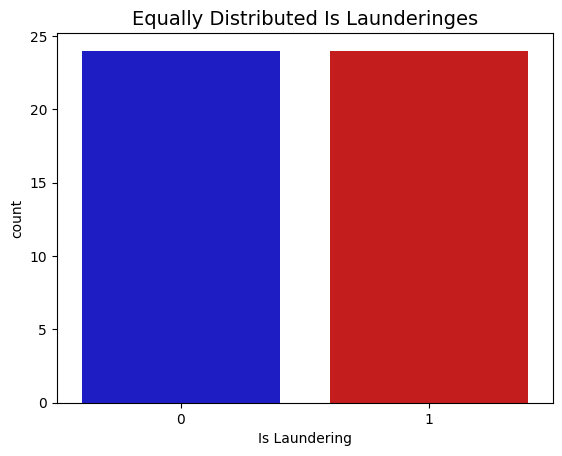

In [44]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is Laundering', palette=colors)
plt.title('Equally Distributed Is Launderinges', fontsize=14)
plt.show()

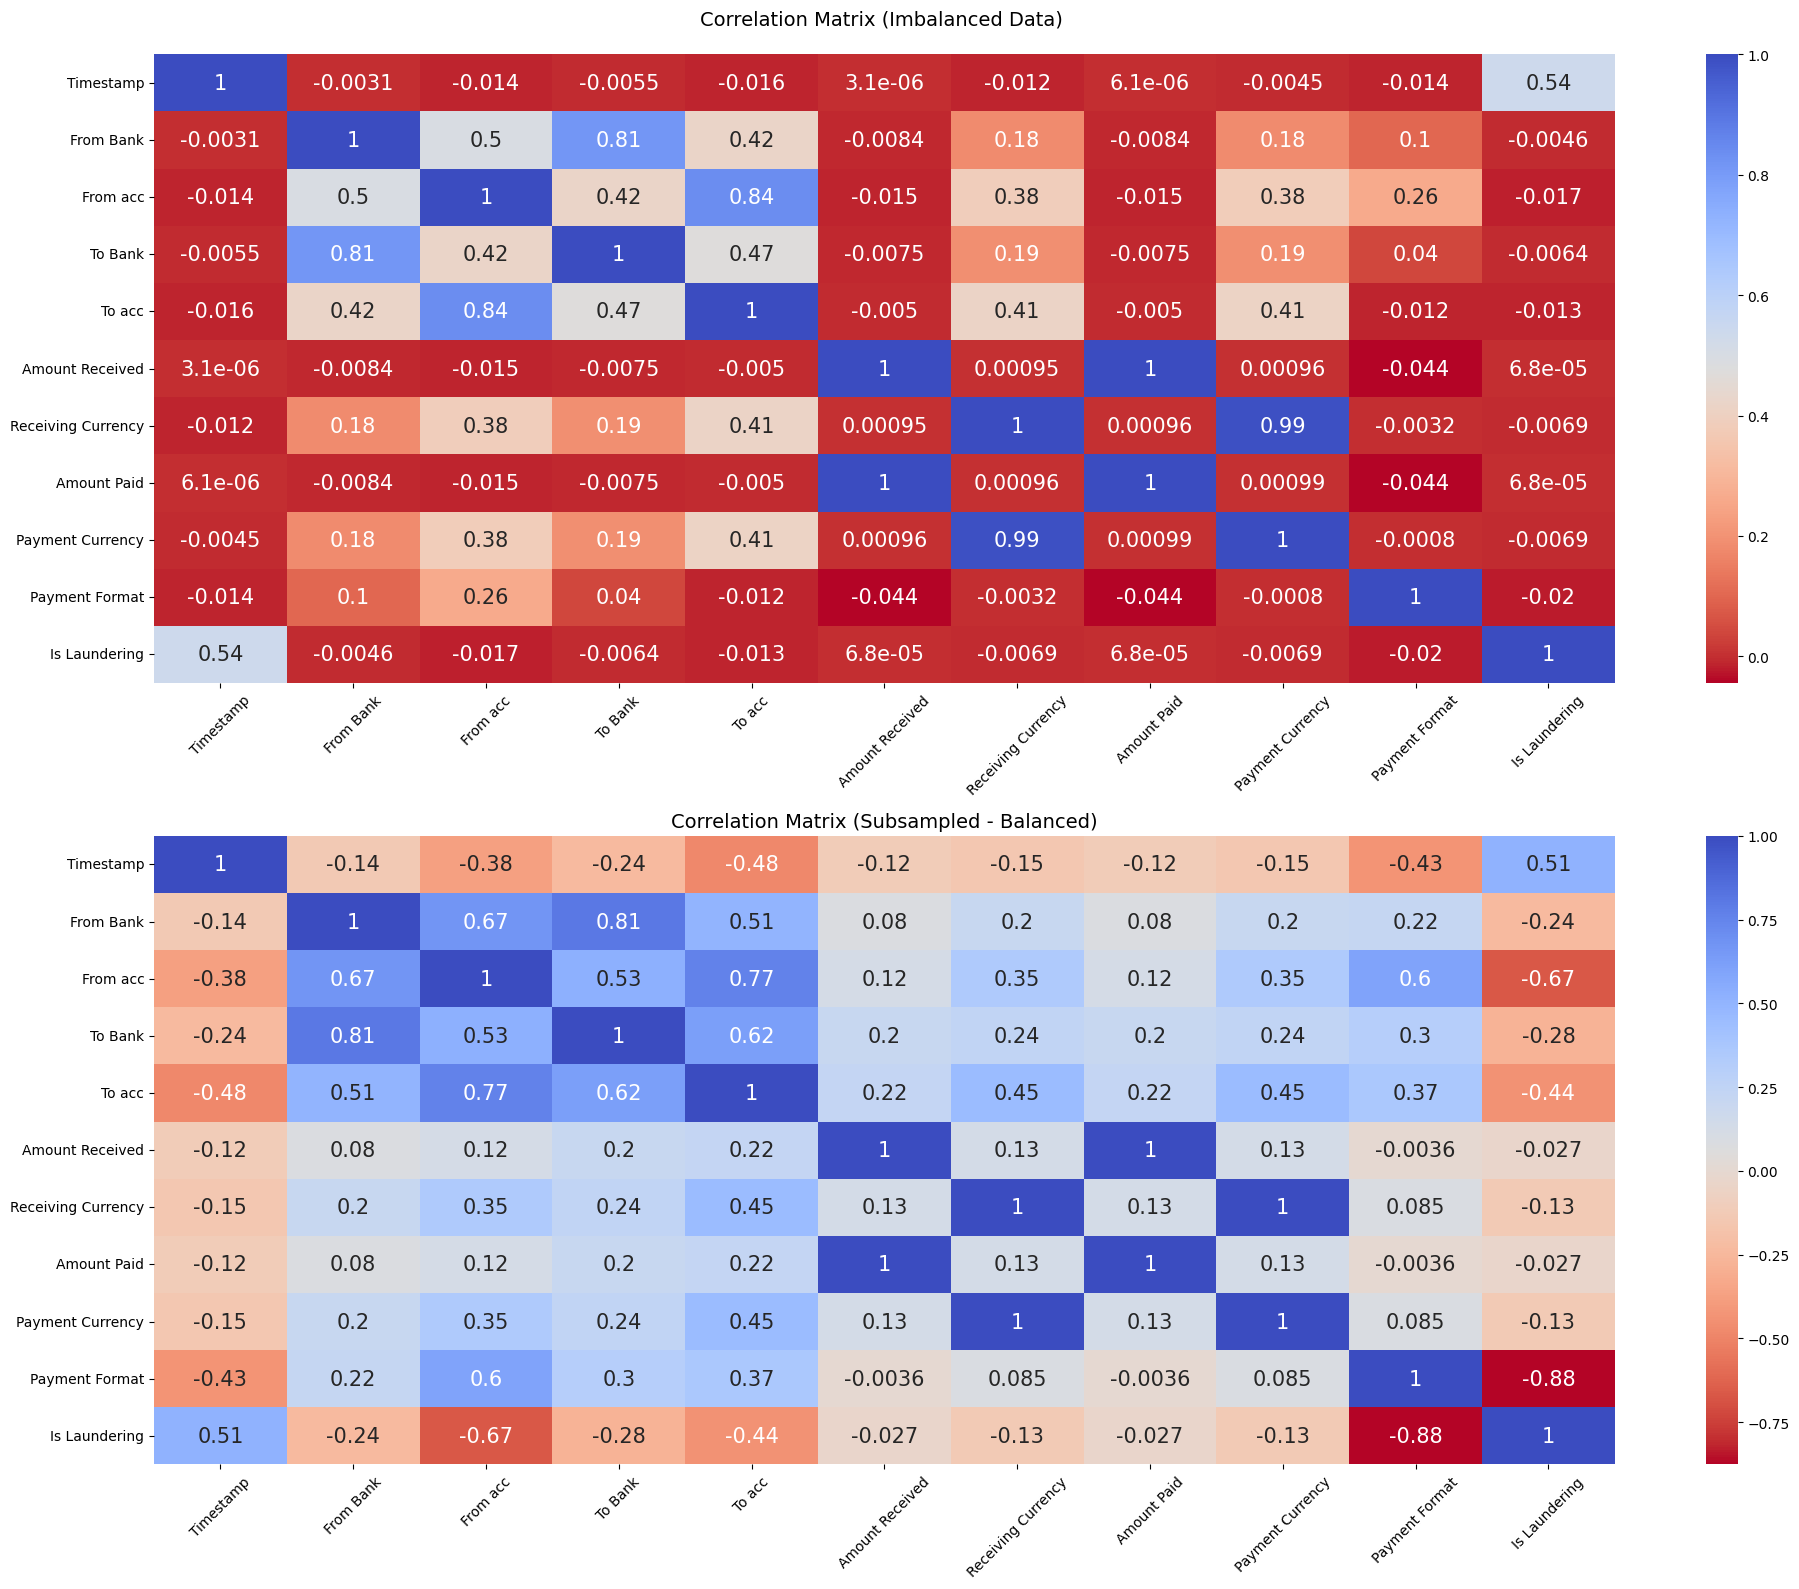

In [45]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))

# Entire DataFrame
corr = data_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Correlation Matrix (Imbalanced Data) \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Subsampled Dataset
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('Correlation Matrix (Subsampled - Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()


<ipython-input-46-22aedf58eb90>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
<ipython-input-46-22aedf58eb90>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])


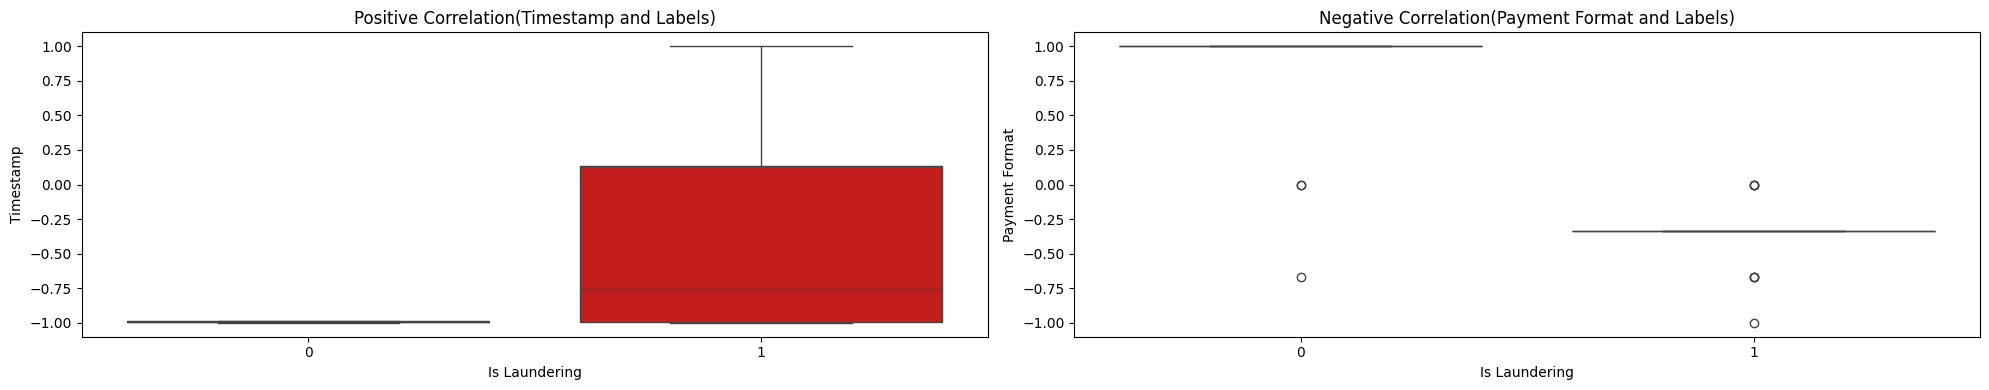

In [46]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

sns.boxplot(x="Is Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')

sns.boxplot(x="Is Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

<ipython-input-47-c7884e028477>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')


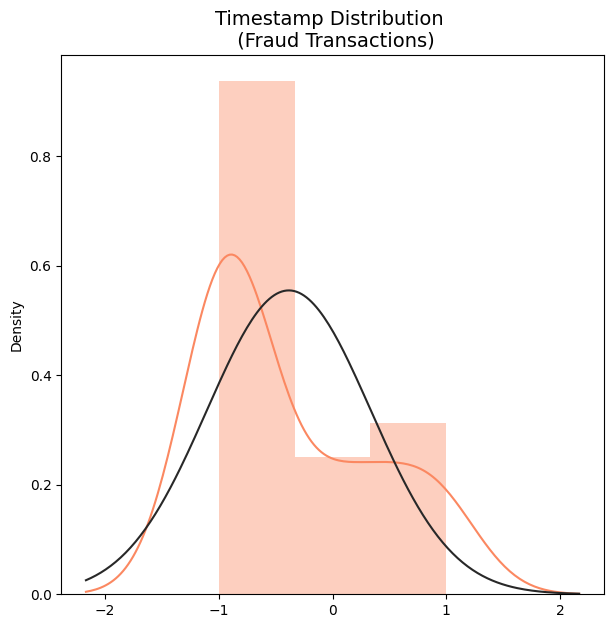

In [47]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [48]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.9914578587699907 | Quartile 75: 0.1331624905087665
iqr: 1.1246203492787572
Cut Off: 1.6869305239181358
Timestamp Lower: -2.6783883826881265
Timestamp Upper: 1.8200930144269023
Feature Timestamp Outliers for Fraud Cases: 0
Timestamp outliers:[]


,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
32278,-0.989370,-0.997125,-0.273755,-0.997125,-0.303025,-0.999697,0.714286,-0.999697,0.714286,1.0,0
137744,-0.992027,-0.991320,-0.446936,-0.991319,-0.473345,-0.999998,-0.428571,-0.999998,-0.428571,1.0,0
78244,-0.993926,-0.916887,0.389429,-0.916877,0.368057,-0.999999,0.714286,-0.999999,0.714286,1.0,0
70595,-0.996583,0.226437,0.280261,0.226585,0.256257,-1.000000,0.714286,-1.000000,0.714286,1.0,0
99095,-0.990129,-0.352288,0.680906,-0.352210,0.666511,-0.992066,0.714286,-0.992066,0.714286,1.0,0


In [49]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def run(data):
    # Undersampling before cross validating (prone to overfit)
    X = data.drop('Is Laundering', axis=1)
    y = data['Is Laundering']

    # Our data is already scaled we should split our training and test sets
    from sklearn.model_selection import train_test_split

    # This is explicitly used for undersampling.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Let's implement simple classifiers
    classifiers = {
        "LogisiticRegression": LogisticRegression(),
        "KNearest": KNeighborsClassifier(),
        "Support Vector Classifier": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier()
    }

    # Wow our scores are getting even high scores even when applying cross validation.
    from sklearn.model_selection import cross_val_score

    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
        test_score = classifier.score(X_test, y_test)
        print("Classifiers: ", classifier.__class__.__name__, "Has a test score of", round(test_score, 2) * 100, "% accuracy score\n")

In [50]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 0.25 s
PCA took 0.0022 s
Truncated SVD took 0.0022 s


b. Use t-SNE and PCA for joint dimensionality reduction.

In [51]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_tsne_and_pca = PCA(n_components=2, random_state=42).fit_transform(X_reduced_tsne)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 0.22 s
PCA took 0.015 s



Visualize the distribution of the new_df after dimensionality reduction.

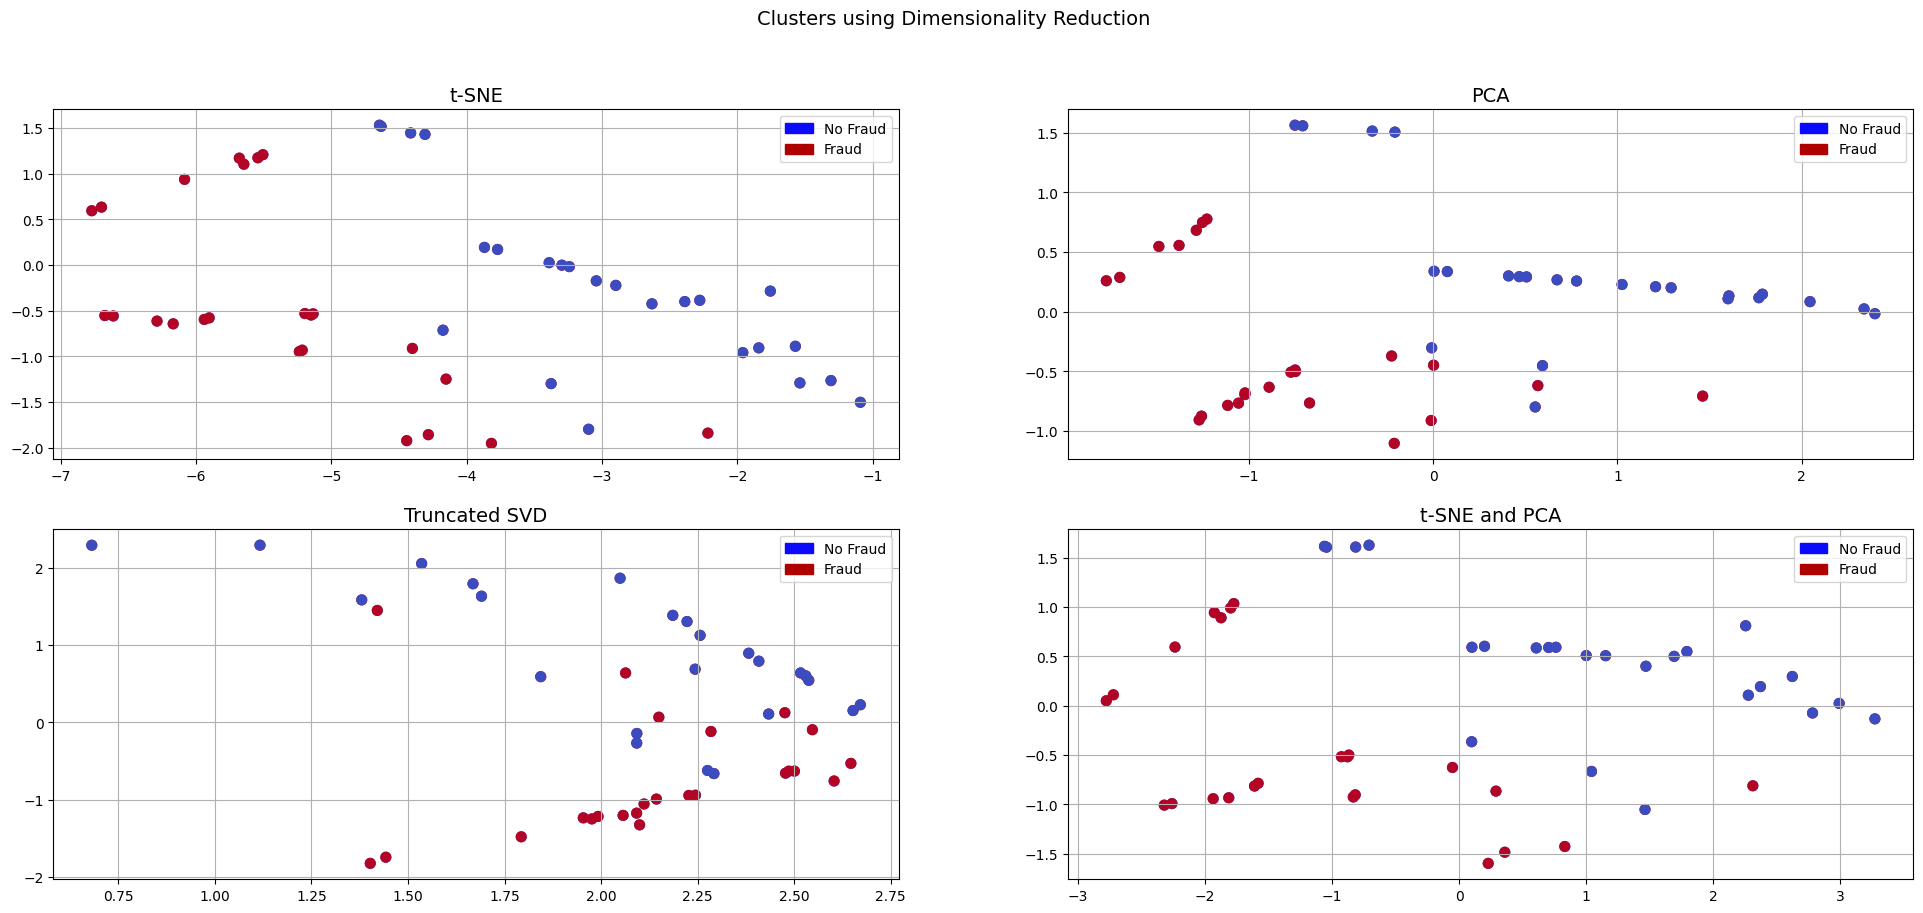

In [52]:
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,10))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

# t-SNE and PCA
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax4.set_title('t-SNE and PCA', fontsize=14)

ax4.grid(True)

ax4.legend(handles=[blue_patch, red_patch])

plt.show()



After visualizing the data using the dimensionality reduction methods mentioned above, it was observed that the difference between fraudulent and non-fraudulent transactions in the dataset is not very distinct.

Next, we will proceed with training.

In [53]:
run(new_df)

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  LogisticRegression Has a test score of 80.0 % accuracy score

Classifiers:  KNeighborsClassifier Has a training score of 89.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a test score of 80.0 % accuracy score

Classifiers:  SVC Has a training score of 95.0 % accuracy score
Classifiers:  SVC Has a test score of 90.0 % accuracy score

Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a test score of 60.0 % accuracy score



In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# Split the dataset into features and target variable
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']



[0]	train-logloss:0.62718	train-error:0.05263	test-logloss:0.64661	test-error:0.10000
[1]	train-logloss:0.57407	train-error:0.05263	test-logloss:0.59928	test-error:0.10000
[2]	train-logloss:0.52635	train-error:0.05263	test-logloss:0.55272	test-error:0.10000
[3]	train-logloss:0.48648	train-error:0.02632	test-logloss:0.51558	test-error:0.00000
[4]	train-logloss:0.44916	train-error:0.02632	test-logloss:0.48784	test-error:0.00000
[5]	train-logloss:0.41459	train-error:0.05263	test-logloss:0.45548	test-error:0.10000
[6]	train-logloss:0.38861	train-error:0.02632	test-logloss:0.42795	test-error:0.00000
[7]	train-logloss:0.36369	train-error:0.02632	test-logloss:0.40973	test-error:0.00000
[8]	train-logloss:0.34374	train-error:0.02632	test-logloss:0.38810	test-error:0.00000
[9]	train-logloss:0.32396	train-error:0.02632	test-logloss:0.36783	test-error:0.00000
[10]	train-logloss:0.30520	train-error:0.02632	test-logloss:0.34991	test-error:0.00000
[11]	train-logloss:0.28883	train-error:0.02632	test-l

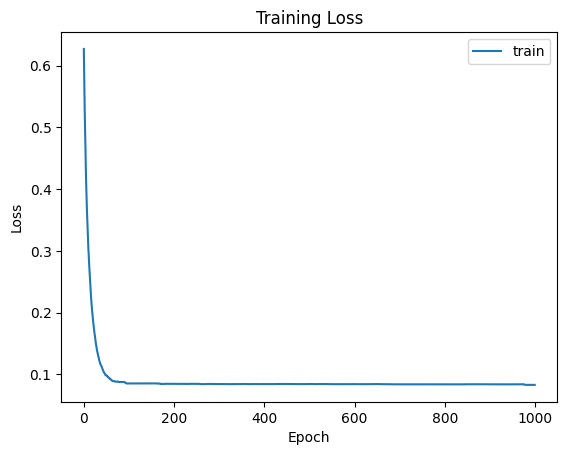

In [55]:
# Plot the training loss curve
plt.plot(train_loss, label='train')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Evaluation Metrics:
Accuracy: 100.0 %
F1 Score: 100.0 %
Recall Score: 100.0 %
Precision Score: 100.0 %


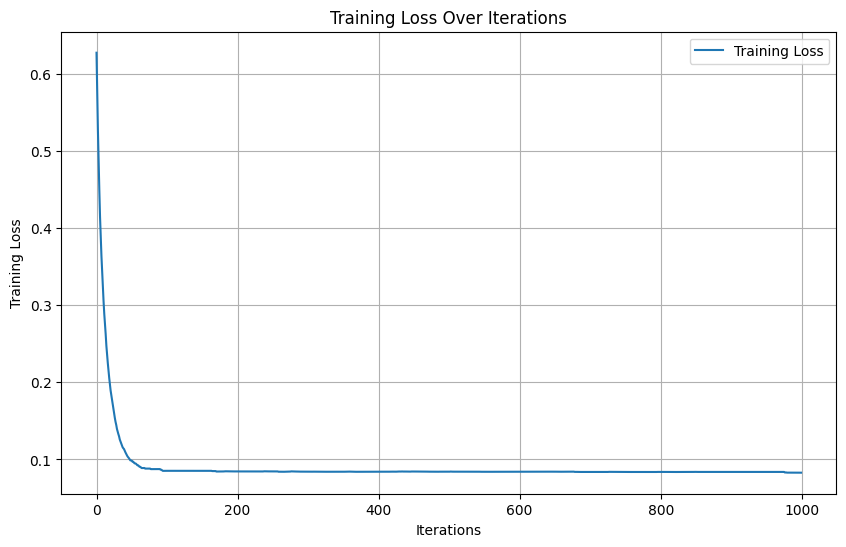

In [56]:
# Calculate additional evaluation metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", round(test_score * 100, 2), "%")
print("F1 Score:", round(f1 * 100, 2), "%")
print("Recall Score:", round(recall * 100, 2), "%")
print("Precision Score:", round(precision * 100, 2), "%")

# Plot the training loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()
